
# Assignment 3

This is a template notebook for Assignment 3.


## Install dependencies and initialization

In [ ]:
# # # The next 8 lines added to be compatible with version changes (2022/10/13).
# change cuda to 11.1
import os
import sys, distutils.core
p = os.getenv('PATH')
ld = os.getenv('LD_LIBRARY_PATH')
os.environ['PATH'] = f"/usr/local/cuda-11.1/bin:{p}"
os.environ['LD_LIBRARY_PATH'] = f"/usr/local/cuda-11.1/lib64:{ld}"
# change pytorch to 1.9.0 compiled with cuda 11.1
#!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))




In [ ]:
!pwd # shows current directory
!ls  # shows all files in this directory
!nvidia-smi # shows the specs and the current status of the allocated GPU

In [3]:
# import some common libraries
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime
from tqdm.notebook import tqdm
from glob import glob
import random
import json
import cv2
import csv
import os

# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch
import copy

# import some common detectron2 utilities
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import transforms as T
from detectron2.data import build_detection_test_loader,build_detection_train_loader
from detectron2.utils.visualizer import GenericMask


setup_logger()

<Logger detectron2 (DEBUG)>

In [4]:
# Make sure that GPU is available for your notebook.
# Otherwise, you need to update the settungs in Runtime -> Change runtime type -> Hardware accelerator
torch.cuda.is_available()

True

In [5]:
# You need to mount your google drive in order to load the data:
from google.colab import drive
drive.mount('/content/drive')
# Put all the corresponding data files in a data folder and put the data folder in a same directory with this notebook.
# Also create an output directory for your files such as the trained models and the output images.

Mounted at /content/drive


In [6]:
# Define the location of current directory, which should contain data/train, data/test, and data/train.json.
# TODO: approx 1 line
BASE_DIR = '/content/drive/My Drive/CMPT_CV_lab3'
OUTPUT_DIR = '{}/output'.format(BASE_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Part 1: Object Detection

### Data Loader

In [7]:
'''
# This function should return a list of data samples in which each sample is a dictionary.
# Make sure to select the correct bbox_mode for the data
# For the test data, you only have access to the images, therefore, the annotations should be empty.
# Other values could be obtained from the image files.
# TODO: approx 35 lines
'''
def get_detection_data(set_name):
  data_dirs = '{}/data'.format(BASE_DIR) #/content/drive/My Drive/CMPT_CV_lab3/data
  print(data_dirs)
  dataset = []
  objs=[]
  old_img=""
  if set_name == 'test':
      for f in tqdm(glob(f'{data_dirs}/test/*')): #/content/drive/My Drive/CMPT_CV_lab3/data/test
          if f.endswith('.png'):
            entry = {}
            width, height = Image.open(f).size
            entry['file_name'] = f
            entry['height'] = int(height)
            entry['width'] = int(width)
            entry['annotations'] = []
            dataset.append(entry)
      return dataset
  else:
    json_file = os.path.join(data_dirs, "train.json")
    with open(json_file) as f:
      imgs_anns = json.load(f)
    for idx, v in enumerate(tqdm(imgs_anns)):
        record = {}
        filename = os.path.join(data_dirs + '/train/', v["file_name"])
        if old_img!=filename:
          dataset.append(record)
          objs = []
          old_img = filename

        width, height = Image.open(filename).size
        record.update({
            "file_name": filename,
            "image_id": idx,
            "height": height,
            "width": width,
        })
        obj = {
                "bbox": v["bbox"],
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": v["segmentation"],
                "category_id": 0,
                "category_name" : v["category_name"],
        }
        objs.append(obj)
        record["annotations"] = objs
    return dataset



In [8]:
'''
# Remember to add your dataset to DatasetCatalog and MetadataCatalog
# Consdier "data_detection_train" and "data_detection_test" for registration
# You can also add an optional "data_detection_val" for your validation by spliting the training data
# TODO: approx 5 lines
'''
DatasetCatalog.clear()
for d in ["train", "test", "validation"]:
    DatasetCatalog.register("planes" + d, lambda d=d: get_detection_data(d))
    MetadataCatalog.get("planes" + d).set(thing_classes=["planes"])
planes_metadata = MetadataCatalog.get("planestrain")


In [ ]:
# dataset_dicts = get_detection_data("train")
print(dataset_dicts)

In [ ]:
'''
# Visualize some samples using Visualizer to make sure that the function works correctly
# TODO: approx 5 lines
'''
# # dataset_dicts = get_detection_data("train")
# for d in random.sample(dataset_dicts, 3):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=planes_metadata, scale=0.5)
#     out = visualizer.draw_dataset_dict(d)
#     cv2_imshow(out.get_image()[:, :, ::-1])
dataset_dicts = get_detection_data("train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=planes_metadata, scale=0.2)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])



### Set Configs

In [15]:
'''
# Set the configs for the detection part in here.
# TODO: approx 15 lines
'''
cfg = get_cfg()
cfg.OUTPUT_DIR = "{}/output/".format(BASE_DIR)
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("planestrain",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []   # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)




In [16]:
from detectron2.data import detection_utils as utils
 # Show how to implement a minimal mapper, similar to the default DatasetMapper
def custom_data(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    # can use other ways to read image
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    # See "Data Augmentation" tutorial for details usage
    transform = [
                    T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                    T.Resize((512,512)),
                    T.RandomBrightness(0.3,2.0),
                    T.RandomContrast(0.5, 1.5),
            ]
    auginput = T.AugInput(image)
    transform = T.Resize((800, 800))(auginput)
    image = torch.from_numpy(auginput.image.transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[:2])
        for annotation in dataset_dict.pop("annotations")
    ]
    dataset_dict["instances"] = utils.filter_empty_instances(utils.annotations_to_instances(annos, image.shape[:2]))
    return dataset_dict


In [18]:
class Custom_Trainer(DefaultTrainer):
   @classmethod
   def custom_train_loader(cls, cfg):
      return build_detection_train_loader(cfg, mapper=custom_data)


### Training

In [19]:
'''
# Create a DefaultTrainer using the above config and train the model
# TODO: approx 5 lines
'''

#trainer = DefaultTrainer(cfg)
trainer = Custom_Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()



[11/13 05:19:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

  0%|          | 0/7980 [00:00<?, ?it/s]

[11/13 05:19:38 d2.data.build]: Removed 0 images with no usable annotations. 198 images left.
[11/13 05:19:38 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   planes   | 7980         |
|            |              |
[11/13 05:19:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/13 05:19:38 d2.data.build]: Using training sampler TrainingSampler
[11/13 05:19:38 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/13 05:19:38 d2.data.common]: Serializing 198 elements to byte tensors and concatenating them all ...
[11/13 05:19:38 d2.data.common]: Serialized dataset takes 15.48 MiB
[11/13 05:19:38 d2.data.build]: Making batched data loader with batch_size=2
[11/13 05:19:38 d2.checkpoint.detection_checkpoint]: 

model_final_68b088.pkl: 421MB [00:32, 13.0MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[11/13 05:20:11 d2.engine.train_loop]: Starting training from iteration 0
[11/13 05:20:46 d2.utils.events]:  eta: 0:26:09  iter: 19  total_loss: 4.349  loss_cls: 0.6889  loss_box_reg: 0.3169  loss_rpn_cls: 2.818  loss_rpn_loc: 0.5028    time: 1.6521  last_time: 1.6775  data_time: 0.0720  last_data_time: 0.0033   lr: 4.9953e-06  max_mem: 6022M
[11/13 05:21:25 d2.utils.events]:  eta: 0:27:20  iter: 39  total_loss: 2.382  loss_cls: 0.6596  loss_box_reg: 0.4466  loss_rpn_cls: 0.7576  loss_rpn_loc: 0.321    time: 1.7206  last_time: 1.6263  data_time: 0.0310  last_data_time: 0.0044   lr: 9.9902e-06  max_mem: 6731M
[11/13 05:22:02 d2.utils.events]:  eta: 0:27:50  iter: 59  total_loss: 1.72  loss_cls: 0.5924  loss_box_reg: 0.3669  loss_rpn_cls: 0.4217  loss_rpn_loc: 0.2648    time: 1.7651  last_time: 1.6440  data_time: 0.0177  last_data_time: 0.0166   lr: 1.4985e-05  max_mem: 6731M
[11/13 05:22:38 d2.utils.events]:  eta: 0:27:26  iter: 79  total_loss: 1.532  loss_cls: 0.5126  loss_box_reg: 0.3

### Evaluation and Visualization

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/MyDrive/CMPT_CV_lab3/output/"

In [21]:
'''
# After training the model, you need to update cfg.MODEL.WEIGHTS
# Define a DefaultPredictor
'''
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[11/13 05:49:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/My Drive/CMPT_CV_lab3/output/model_final.pth ...


In [ ]:
'''
# Visualize the output for 3 random test samples
# TODO: approx 10 lines
'''
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_detection_data("test")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],metadata=planes_metadata, scale=0.2,)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [23]:
'''
# Use COCOEvaluator and build_detection_train_loader
# You can save the output predictions using inference_on_dataset
# TODO: approx 5 lines
'''
evaluator = COCOEvaluator("planestrain", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "planestrain")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[11/13 05:50:44 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[11/13 05:50:44 d2.evaluation.coco_evaluation]: Trying to convert 'planestrain' to COCO format ...
[11/13 05:50:44 d2.data.datasets.coco]: Converting annotations of dataset 'planestrain' to COCO format ...)
/content/drive/My Drive/CMPT_CV_lab3/data


  0%|          | 0/7980 [00:00<?, ?it/s]

[11/13 05:50:51 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[11/13 05:50:52 d2.data.datasets.coco]: Conversion finished, #images: 198, #annotations: 7980
[11/13 05:50:52 d2.data.datasets.coco]: Caching COCO format annotations at './output/planestrain_coco_format.json' ...
/content/drive/My Drive/CMPT_CV_lab3/data


  0%|          | 0/7980 [00:00<?, ?it/s]

[11/13 05:51:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/13 05:51:02 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/13 05:51:02 d2.data.common]: Serializing 198 elements to byte tensors and concatenating them all ...
[11/13 05:51:02 d2.data.common]: Serialized dataset takes 15.48 MiB
[11/13 05:51:02 d2.evaluation.evaluator]: Start inference on 198 batches
[11/13 05:51:08 d2.evaluation.evaluator]: Inference done 11/198. Dataloading: 0.0395 s/iter. Inference: 0.2422 s/iter. Eval: 0.0003 s/iter. Total: 0.2821 s/iter. ETA=0:00:52
[11/13 05:51:13 d2.evaluation.evaluator]: Inference done 29/198. Dataloading: 0.0361 s/iter. Inference: 0.2484 s/iter. Eval: 0.0003 s/iter. Total: 0.2850 s/iter. ETA=0:00:48
[11/13 05:51:18 d2.evaluation.evaluator]: Inference done 49/198. Dataloading: 0.0204 s/iter. Inference: 0.252

### Improvements

For this part, you can bring any improvement which you have by adding new input parameters to the previous functions or defining new functions and variables.

In [ ]:
'''
# Bring any changes and updates regarding the improvement in here
'''


## Part 2: Semantic Segmentation

### Data Loader

In [9]:
'''
# Write a function that returns the cropped image and corresponding mask regarding the target bounding box
# idx is the index of the target bbox in the data
# high-resolution image could be passed or could be load from data['file_name']
# You can use the mask attribute of detectron2.utils.visualizer.GenericMask
#     to convert the segmentation annotations to binary masks
# TODO: approx 10 lines
'''

def get_instance_sample(data, idx, img=None):
  filename = data["file_name"]
  # img = cv2.imread(filename)
  # width, height = Image.open(filename).size
  width, height = data["width"], data["height"]
  anno = data["annotations"][idx]
  bbox = anno["bbox"]
  x, y, w, h = map(int, bbox)

  obj_img = img[y:y+h, x:x+w]
  #Resizing to 128x128
  obj_img = cv2.resize(obj_img, (128, 128), interpolation = cv2.INTER_AREA)

  #Applying Mask and resize to 128x128
  obj_mask = GenericMask(anno["segmentation"], data['height'], data['width']).mask
  obj_mask = obj_mask[y:y + h,x:x + w]
  obj_mask = cv2.resize(obj_mask, (128, 128), interpolation = cv2.INTER_AREA)

  return obj_img, obj_mask





In [10]:
'''
# We have provided a template data loader for your segmentation training
# You need to complete the __getitem__() function before running the code
# You may also need to add data augmentation or normalization in here
'''

class PlaneDataset(Dataset):
  def __init__(self, set_name, data_list):
      self.transforms = transforms.Compose([
          transforms.ToTensor(), # Converting the image to tensor and change the image format (Channels-Last => Channels-First)
      ])
      self.set_name = set_name
      self.data = data_list
      self.instance_map = []
      self.img_dict = {}
      for i, d in tqdm(enumerate(self.data),desc='Processing', unit='item'):
        img_path = d["file_name"]
        img = cv2.imread(img_path)
        self.img_dict[img_path] = img
        for j in range(len(d['annotations'])):
          self.instance_map.append([i,j])

  '''
  # you can change the value of length to a small number like 10 for debugging of your training procedure and overfeating
  # make sure to use the correct length for the final training
  '''
  def __len__(self):
      return len(self.instance_map)

  def numpy_to_tensor(self, img, mask):
    if self.transforms is not None:
        img = self.transforms(img)
    img = torch.tensor(img, dtype=torch.float)
    mask = torch.tensor(mask, dtype=torch.float)
    return img, mask

  '''
  # Complete this part by using get_instance_sample function
  # make sure to resize the img and mask to a fixed size (for example 128*128)
  # you can use "interpolate" function of pytorch or "numpy.resize"
  # TODO: 5 lines
  '''
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
    idx = self.instance_map[idx]
    data = self.data[idx[0]]
    img_path = data["file_name"]
    img_read = self.img_dict[img_path]

    img, mask = get_instance_sample(data,idx[1], img_read)
    img, mask = self.numpy_to_tensor(img, mask)
    mask = torch.unsqueeze(mask,0)

    return img, mask

def get_plane_dataset(set_name='train', batch_size=2):
    my_data_list = DatasetCatalog.get("planes{}".format(set_name))
    dataset = PlaneDataset(set_name, my_data_list)
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=4,
                                              pin_memory=True, shuffle=True)
    return loader, dataset

### Network

In [11]:
'''
# convolution module as a template layer consists of conv2d layer, batch normalization, and relu activation
'''
class conv(nn.Module):
    def __init__(self, in_ch, out_ch, activation=True):
        super(conv, self).__init__()
        if(activation):
          self.layer = nn.Sequential(
             nn.Conv2d(in_ch, out_ch, 3, padding=1),
             nn.BatchNorm2d(out_ch),
             nn.ReLU(inplace=True)
          )
        else:
          self.layer = nn.Sequential(
             nn.Conv2d(in_ch, out_ch, 3, padding=1)
             )

    def forward(self, x):
        x = self.layer(x)
        return x

'''
# downsampling module equal to a conv module followed by a max-pool layer
'''
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.layer = nn.Sequential(
            conv(in_ch, out_ch),
            nn.MaxPool2d(2)
            )

    def forward(self, x):
        x = self.layer(x)
        return x

'''
# upsampling module equal to a upsample function followed by a conv module
'''
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch, 2, stride=2)

        self.conv = conv(in_ch, out_ch)

    def forward(self, x):
        y = self.up(x)
        y = self.conv(y)
        return y

'''
# the main model which you need to complete by using above modules.
# you can also modify the above modules in order to improve your results.
'''

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # Encoder

        self.input_conv = conv(3, 8)
        self.down_1 = down(8, 16)
        self.down_2 = down(16, 32)
        self.down_3 = down(32, 64)
        self.down_4 = down(64, 128)
        self.down_5 = down(128, 256)
        self.down_6 = down(256, 512)

        # Decoder

        self.up_1 = up(512, 256)
        self.up_2 = up(256, 128)
        self.up_3 = up(128, 64)
        self.up_4 = up(64, 32)
        self.up_5 = up(32, 16)
        self.up_6 = up(16, 8)
        self.up_7 = conv(8, 3)
        self.output_conv = conv(3, 1, False) # ReLu activation is removed to keep the logits for the loss function

    def forward(self, input):
      y = self.input_conv(input)
      y = self.down_1(y)
      y = self.down_2(y)
      y = self.down_3(y)
      y = self.down_4(y)
      y = self.down_5(y)
      y = self.down_6(y)

      y = self.up_1(y)
      y = self.up_2(y)
      y = self.up_3(y)
      y = self.up_4(y)
      y = self.up_5(y)
      y = self.up_6(y)
      y = self.up_7(y)

      output = self.output_conv(y)
      return output


### Training

In [30]:
'''
# The following is a basic training procedure to train the network
# You need to update the code to get the best performance
# TODO: approx ? lines
'''
import warnings

# Set the hyperparameters
num_epochs = 50
batch_size = 25
learning_rate = 0.01
weight_decay = 1e-5

model = MyModel() # initialize the model
model = model.cuda() # move the model to GPU
loader, _ = get_plane_dataset('train', batch_size) # initialize data_loader
crit = nn.BCEWithLogitsLoss() # Define the loss function
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Initialize the optimizer as SGD

#To plot
training_losses = []

# start the training procedure
for epoch in range(num_epochs):
  total_loss = 0
  warnings.filterwarnings('ignore')
  for (img, mask) in tqdm(loader):
    img = torch.tensor(img, device=torch.device('cuda'), requires_grad = True)
    mask = torch.tensor(mask, device=torch.device('cuda'), requires_grad = True)
    pred = model(img)
    loss = crit(pred, mask)
    optim.zero_grad()
    loss.backward()
    optim.step()
    total_loss += loss.cpu().data
  average_loss = total_loss/len(loader)
  print("Epoch: {}, Loss: {}".format(epoch, average_loss))
  training_losses.append(average_loss)
  torch.save(model.state_dict(), '{}/output/{}_segmentation_model.pth'.format(BASE_DIR, epoch))


'''
# Saving the final model
'''
torch.save(model.state_dict(), '{}/output/final_segmentation_model.pth'.format(BASE_DIR))




/content/drive/My Drive/CMPT_CV_lab3/data


  0%|          | 0/7980 [00:00<?, ?it/s]

Processing: 0item [00:00, ?item/s]

  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.5831793546676636


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.3896265923976898


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.3053359091281891


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.2721537947654724


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.252056747674942


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.23760154843330383


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.22546179592609406


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.21646246314048767


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.20871901512145996


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.20139113068580627


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.19472740590572357


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.18901048600673676


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.1839524358510971


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.17900249361991882


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.1746756136417389


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.17043763399124146


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.1667921245098114


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.16461709141731262


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.15913750231266022


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.1564086228609085


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.15329203009605408


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.1502380073070526


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.14759030938148499


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.14512410759925842


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.14322730898857117


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.13997064530849457


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.13758710026741028


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.1354721188545227


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.1335926353931427


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.13083627820014954


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.12867888808250427


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 31, Loss: 0.12747988104820251


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 32, Loss: 0.12551257014274597


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.12359456717967987


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.12206480652093887


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.12080264091491699


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.11845473200082779


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.11709900945425034


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 38, Loss: 0.11622462421655655


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 39, Loss: 0.11442716419696808


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 40, Loss: 0.11358460038900375


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 41, Loss: 0.11157079041004181


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 42, Loss: 0.11056430637836456


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 43, Loss: 0.10941106081008911


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 44, Loss: 0.1079757958650589


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 45, Loss: 0.10708971321582794


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 46, Loss: 0.10574791580438614


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 47, Loss: 0.10440975427627563


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 48, Loss: 0.10424746572971344


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch: 49, Loss: 0.10339158773422241


NameError: ignored

### Evaluation and Visualization

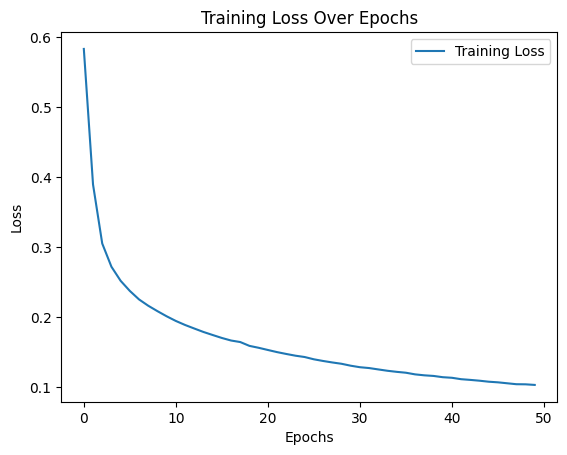

In [32]:
import matplotlib.pyplot as plt
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

torch.save(model.state_dict(), '{}/output/final_segmentation_model.pth'.format(BASE_DIR))


In [ ]:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/MyDrive/CMPT_CV_lab3/output/"

In [ ]:
batch_size = 1
model = MyModel().cuda()
model.load_state_dict(torch.load('{}/output/final_segmentation_model.pth'.format(BASE_DIR)))
model = model.eval() # chaning the model to evaluation mode will fix the bachnorm layers
loader, dataset = get_plane_dataset('train', batch_size)


total_iou = 0
count = 0

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


for (img, mask) in tqdm(loader):
  count+=1
  with torch.no_grad():
    img = img.cuda()
    mask = mask.cpu()
    pred = model(img).cpu()

    #reference: https://hasty.ai/docs/mp-wiki/metrics/iou-intersection-over-union
    pred = pred>0.5
    intersection = (pred*mask).sum(dim=(2,3))
    union = (pred+mask).sum(dim=(2,3)) - intersection
    iou = intersection / union
    total_iou += iou.sum().item()

mean_iou = total_iou/count
print("\n #images: {}, Mean IoU: {}".format(count, mean_iou))





In [25]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [ ]:
'''
# Visualize 3 sample outputs
# TODO: approx 5 lines
'''
loader, dataset = get_plane_dataset('train', 3)

# Get a batch from the dataloader
img, mask = next(iter(loader))

# Move to GPU and make predictions
with torch.no_grad():
    img, pred = img.to('cuda'), mask.to('cuda')
    pred = model(img)
    for i in range(3):
        # Convert to PILImage
        original_img = transforms.ToPILImage()(img[i].cpu())

        # Process and display predicted and masked images
        predicted = np.rint(sigmoid(pred[i].cpu().numpy()[0])) * 255
        masked = np.array(mask[i].cpu().numpy()[0]) * 255

        original_img = Image.fromarray(np.uint8(original_img))

        # Resize predicted and masked images to match the size of the original image
        predicted = Image.fromarray(np.uint8(predicted)).resize(original_img.size)
        masked = Image.fromarray(np.uint8(masked)).resize(original_img.size)

        # Convert to have the same number of channels
        new_img = original_img.convert("RGB")
        masked = masked.convert("RGB")
        predicted = predicted.convert("RGB")

        # Concatenate images horizontally
        combined_image = Image.fromarray(np.hstack((np.array(new_img), np.array(masked), np.array(predicted))))

        # Display the combined image
        cv2_imshow(np.array(combined_image))







## Part 3: Instance Segmentation

In this part, you need to obtain the instance segmentation results for the test data by using the trained segmentation model in the previous part and the detection model in Part 1.

### Get Prediction

In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def get_prediction_mask(my_data, data_type):
    img = cv2.imread(my_data['file_name'])

    if data_type == "test":
        prediction_for_img = predictor(img)['instances'] # use the model from part 1 to get the bounding boxes
        pred_masks = np.zeros([my_data['height'], my_data['width']])
        imgs = []
        # Getting the bounding boxes from the pretrained model and
        # Segmentation from the other model
        for i in range(len(prediction_for_img)):

            y1, x1, y2, x2 = np.array(np.floor(list(prediction_for_img[i]._fields['pred_boxes'])[0].cpu().numpy()), dtype=np.uint32)

            to_be_masked = cv2.resize(img[x1:x2, y1:y2], (128, 128), interpolation=cv2.INTER_AREA)

            input_tensor = torch.tensor(transforms.ToTensor()(to_be_masked))

            # Set pred_mask
            pred_mask = np.where(pred_masks[x1:x2, y1:y2] == 0, 10000, pred_masks[x1:x2, y1:y2])

            # Move the input tensor to the GPU if available
            if torch.cuda.is_available():
                input_tensor = input_tensor.to('cuda')

            # Make a prediction using the model and move the result to the CPU
            cpu_mask = model(input_tensor.unsqueeze(0)).cpu().detach().numpy()[0]


            # Reshape and threshold the cpu_mask
            prediction_mask = np.rint(sigmoid(cv2.resize(cpu_mask[0], (y2-y1, x2-x1), interpolation=cv2.INTER_AREA))) * (i + 1)


            # Calculate overlapping values
            overlapping_values = np.minimum(pred_mask, prediction_mask)

            # Set 1000 to 0
            overlapping_values = np.where(overlapping_values == 10000, 0, overlapping_values)

            # Update pred_masks
            pred_masks[x1:x2, y1:y2] = overlapping_values

    elif data_type == "train":
        #similar to "test":

        pred_masks = np.zeros([my_data['height'], my_data['width']])
        imgs = []

        for i,j in enumerate(my_data['annotations']):
            y1, x1, y2, x2 = j['bbox']


            to_be_masked = cv2.resize(img[x1:x2, y1:y2], (128, 128), interpolation=cv2.INTER_AREA)


            input_tensor = torch.tensor(transforms.ToTensor()(to_be_masked))

            pred_mask = np.where(pred_masks[x1:x2, y1:y2] == 0, 10000, pred_masks[x1:x2, y1:y2])

            if torch.cuda.is_available():
                input_tensor = input_tensor.to('cuda')

            cpu_mask = model(input_tensor.unsqueeze(0)).cpu().detach().numpy()[0]


            prediction_mask = np.rint(sigmoid(cv2.resize(cpu_mask[0], (y2-y1, x2-x1), interpolation=cv2.INTER_AREA))) * (i + 1)



            overlapping_values = np.minimum(pred_mask, prediction_mask)

            overlapping_values = np.where(overlapping_values == 10000, 0, overlapping_values)

            pred_masks[x1:x2, y1:y2] = overlapping_values



    # Getting the true segmentations from the data
    height, width = my_data['height'], my_data['width']
    true_mask = np.zeros((height, width))

    for j, annotation in enumerate(my_data['annotations']):
        bbox = annotation['bbox']
        y1, x1, y2, x2 = [int(i) for i in bbox]
        x2 += x1
        y2 += y1
        local_true_mask = detectron2.utils.visualizer.GenericMask(annotation['segmentation'], height, width).mask

        region = true_mask[x1:x2, y1:y2]
        local_region = local_true_mask[x1:x2, y1:y2] * (j + 1)

        # Update only the overlapping region
        true_mask[x1:x2, y1:y2] = np.maximum(region, local_region)

    gt_mask = torch.tensor(true_mask, device=torch.device('cuda'))
    pred_mask = torch.tensor(pred_masks, device=torch.device('cuda'))

    return img, gt_mask, pred_mask

### Visualization and Submission

In [ ]:
import matplotlib.pyplot as plt
dataset = get_detection_data('train.json')
for i in np.random.randint(0,50,3):
    img, true_mask, pred_mask = get_prediction_mask(dataset[i], "train")
    pred_mask = pred_mask.cpu().numpy()
    true_mask = true_mask.cpu().numpy()
    max_val = pred_mask.max()
    fact = 255./max_val
    pred_mask= fact
    max_val = true_mask.max()
    fact = 255./max_val
    true_mask= fact

    resized_img = cv2.resize(img, (img.shape[1] // 3, img.shape[0] // 3), interpolation=cv2.INTER_AREA)
    resized_true_mask = cv2.resize(true_mask, (true_mask.shape[1] // 3, true_mask.shape[0] // 3), interpolation=cv2.INTER_AREA)
    resized_pred_mask = cv2.resize(pred_mask, (pred_mask.shape[1] // 3, pred_mask.shape[0] // 3), interpolation=cv2.INTER_AREA)



    # Display the resized images and masks using plt.imshow
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(resized_img)
    plt.title('Resized Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(resized_true_mask)
    plt.title('Resized True Mask')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(resized_pred_mask)
    plt.title('Resized Predicted Mask')
    plt.axis('off')

    plt.show()

In [ ]:
'''
# ref: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# https://www.kaggle.com/c/airbus-ship-detection/overview/evaluation
'''
def rle_encoding(x):
    '''
    x: pytorch tensor on gpu, 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = torch.where(torch.flatten(x.long())==1)[0]
    if(len(dots)==0):
      return []
    inds = torch.where(dots[1:]!=dots[:-1]+1)[0]+1
    inds = torch.cat((torch.tensor([0], device=torch.device('cuda'), dtype=torch.long), inds))
    tmpdots = dots[inds]
    inds = torch.cat((inds, torch.tensor([len(dots)], device=torch.device('cuda'))))
    inds = inds[1:] - inds[:-1]
    runs = torch.cat((tmpdots, inds)).reshape((2,-1))
    runs = torch.flatten(torch.transpose(runs, 0, 1)).cpu().data.numpy()
    return ' '.join([str(i) for i in runs])

In [ ]:
'''
# You need to upload the csv file on kaggle
# The speed of your code in the previous parts highly affects the running time of this part
'''

preddic = {"ImageId": [], "EncodedPixels": []}

'''
# Writing the predictions of the training set
'''
my_data_list = DatasetCatalog.get("planes{}".format('train'))
for i in tqdm(range(len(my_data_list)), position=0, leave=True):
  sample = my_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, true_mask, pred_mask = get_prediction_mask(sample, "train")
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for index in inds:
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index)
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)

'''
# Writing the predictions of the test set
'''

my_data_list = DatasetCatalog.get("planes{}".format('test'))
for i in tqdm(range(len(my_data_list)), position=0, leave=True):
  sample = my_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, true_mask, pred_mask = get_prediction_mask(sample, "test")
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for j, index in enumerate(inds):
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index).double()
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)

pred_file = open("{}/pred.csv".format(BASE_DIR), 'w')
pd.DataFrame(preddic).to_csv(pred_file, index=False)
pred_file.close()


## Part 4: Mask R-CNN

For this part you need to follow a same procedure to part 2 with the configs of Mask R-CNN, other parts are generally the same as part 2.

### Data Loader

In [6]:
'''
# This function should return a list of data samples in which each sample is a dictionary.
# Make sure to select the correct bbox_mode for the data
# For the test data, you only have access to the images, therefore, the annotations should be empty.
# Other values could be obtained from the image files.
# TODO: approx 35 lines
'''
def get_detection_data(set_name):
  data_dirs = '{}/data'.format(BASE_DIR) #/content/drive/My Drive/CMPT_CV_lab3/data
  print(data_dirs)
  dataset = []
  objs=[]
  old_img=""
  if set_name == 'test':
      for f in tqdm(glob(f'{data_dirs}/test/*')): #/content/drive/My Drive/CMPT_CV_lab3/data/test
          if f.endswith('.png'):
            entry = {}
            width, height = Image.open(f).size
            entry['file_name'] = f
            entry['height'] = int(height)
            entry['width'] = int(width)
            entry['annotations'] = []
            dataset.append(entry)
      return dataset
  else:
    json_file = os.path.join(data_dirs, "train.json")
    with open(json_file) as f:
      imgs_anns = json.load(f)
    for idx, v in enumerate(tqdm(imgs_anns)):
        record = {}
        filename = os.path.join(data_dirs + '/train/', v["file_name"])
        if old_img!=filename:
          dataset.append(record)
          objs = []
          old_img = filename

        width, height = Image.open(filename).size
        record.update({
            "file_name": filename,
            "image_id": idx,
            "height": height,
            "width": width,
        })
        obj = {
                "bbox": v["bbox"],
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": v["segmentation"],
                "category_id": 0,
                "category_name" : v["category_name"],
        }
        objs.append(obj)
        record["annotations"] = objs
    return dataset






In [7]:
DatasetCatalog.clear()
for d in ["train", "test", "validation"]:
    DatasetCatalog.register("planes" + d, lambda d=d: get_detection_data(d))
    MetadataCatalog.get("planes" + d).set(thing_classes=["planes"])
planes_metadata = MetadataCatalog.get("planestrain")


### Network

In [10]:
'''
# Set the configs for the detection part in here.
# TODO: approx 15 lines
'''
cfg = get_cfg()
cfg.OUTPUT_DIR = "{}/output/".format(BASE_DIR)
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("planestrain",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []   # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)




In [11]:
from detectron2.data import detection_utils as utils
 # Show how to implement a minimal mapper, similar to the default DatasetMapper
def custom_data(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    # can use other ways to read image
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    # See "Data Augmentation" tutorial for details usage
    transform = [
                    T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                    T.Resize((512,512)),
                    T.RandomBrightness(0.3,2.0),
                    T.RandomContrast(0.5, 1.5),
            ]
    auginput = T.AugInput(image)
    transform = T.Resize((800, 800))(auginput)
    image = torch.from_numpy(auginput.image.transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[:2])
        for annotation in dataset_dict.pop("annotations")
    ]
    dataset_dict["instances"] = utils.filter_empty_instances(utils.annotations_to_instances(annos, image.shape[:2]))
    return dataset_dict


### Training

In [13]:
class Custom_Trainer(DefaultTrainer):
   @classmethod
   def custom_train_loader(cls, cfg):
      return build_detection_train_loader(cfg, mapper=custom_data)

In [ ]:
trainer = Custom_Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

### Evaluation and Visualization

In [15]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[11/13 01:02:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/My Drive/CMPT_CV_lab3/output/model_final.pth ...


In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_detection_data("test")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],metadata=planes_metadata, scale=0.2,)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
'''
# Use COCOEvaluator and build_detection_train_loader
# You can save the output predictions using inference_on_dataset
# TODO: approx 5 lines
'''
evaluator = COCOEvaluator("planestrain", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "planestrain")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[11/13 00:29:19 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
/content/drive/My Drive/CMPT_CV_lab3/data


  0%|          | 0/7980 [00:00<?, ?it/s]

[11/13 00:29:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/13 00:29:27 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/13 00:29:27 d2.data.common]: Serializing 198 elements to byte tensors and concatenating them all ...
[11/13 00:29:27 d2.data.common]: Serialized dataset takes 15.48 MiB
[11/13 00:29:27 d2.evaluation.evaluator]: Start inference on 198 batches
[11/13 00:29:33 d2.evaluation.evaluator]: Inference done 11/198. Dataloading: 0.0013 s/iter. Inference: 0.3198 s/iter. Eval: 0.0004 s/iter. Total: 0.3215 s/iter. ETA=0:01:00
[11/13 00:29:38 d2.evaluation.evaluator]: Inference done 26/198. Dataloading: 0.0202 s/iter. Inference: 0.3209 s/iter. Eval: 0.0004 s/iter. Total: 0.3416 s/iter. ETA=0:00:58
[11/13 00:29:43 d2.evaluation.evaluator]: Inference done 42/198. Dataloading: 0.0121 s/iter. Inference: 0.320